# Tracking with ARCOS.px vs TrackMate
This Notebook plots the MOTA and MOTP metrics for synthetic data generated by the `simulation_tracking.py` script.

In [1]:
from IPython.display import display, clear_output
import random
import os
import re
from pathlib import Path
from typing import Tuple, Optional

import numpy as np
from math import gamma, sqrt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import brentq

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import plotnine as p9
import colorsys

import seaborn as sns

from skimage import io

plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['font.family'] = 'serif'


## Parameter definitions

In [6]:
# Update the plot parameters
plt.rcParams.update({'svg.fonttype': 'none'})
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.size': 16})
# Set black theme
plt.style.use('dark_background')

base_path = '../'

sim_types = ['sim_circles', 'sim_directional', 'sim_target_pattern', 'sim_chaotic']
sim_names = ['Circles', 'Directional', 'Target Pattern', 'Chaotic']

rng = np.random.default_rng(42)  # optional, for reproducibility

## Function definitions

In [7]:
def create_noise_level_plot(sim_type, snr_levels, run_folder, plot_folder, frame_num=150):
    fig, axs = plt.subplots(3, len(snr_levels), figsize=(8, 4))

    colormap = plt.cm.tab20
    
    # Load and plot specific frame for each noise level
    for i, snr in enumerate(snr_levels):
        # Load only frame 150 from RAW data
        raw_path = f"{run_folder}/{sim_type}_snr_{snr}/00_GT/RAW"
        gt_path = f"{run_folder}/{sim_type}_snr_{snr}/00_GT/TRA"
        tracked_path = f"{run_folder}/{sim_type}_snr_{snr}/00_RES"
        raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])
        gt_files = sorted([f for f in os.listdir(gt_path) if f.endswith('.tif')])
        tracked_files = sorted([f for f in os.listdir(tracked_path) if f.endswith('.tif')])
        frame_file = raw_files[frame_num]
        raw_array = io.imread(os.path.join(raw_path, frame_file))

        frame_file = gt_files[frame_num]
        gt_array = io.imread(os.path.join(gt_path, frame_file))

        frame_file = tracked_files[frame_num]
        tracked_array = io.imread(os.path.join(tracked_path, frame_file))
        
        # Normalize RAW data
        raw_norm = (raw_array - raw_array.min()) / (raw_array.max() - raw_array.min())
        max_val = max(tracked_array.max(), gt_array.max())

        # Create random color mapping with tab20 colormap for every value up to max_val
        np.random.seed(0)
        mapping = np.random.choice(np.arange(0, 20), max_val + 1)
        mapping = np.asarray(colormap.colors)[mapping.flatten().astype(int)]

        mapping = np.insert(mapping, 0, [1, 1, 1], axis=0)

        custom_cmap = matplotlib.colors.ListedColormap(mapping)
        
        # Plot RAW data
        axs[0, i].imshow(raw_norm, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        axs[1, i].imshow(gt_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        axs[2, i].imshow(tracked_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        
        # Set title and disable ticks
        axs[0, i].set_title(f'SNR {snr.split(".")[0]} dB')
    

    # Set row labels
    row_labels = ['Raw Data', 'Ground Truth', 'Tracking Result']
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label, rotation=90, labelpad=10)


    for ax_flat in axs.flatten():
        ax_flat.tick_params(axis='both', which='both', bottom=False, top=False,
                            labelbottom=False, right=False, left=False, labelleft=False)
            
        # Set spine width
        for spine in ax_flat.spines.values():
            spine.set_linewidth(1)
    
    plt.tight_layout()

    # plot the colorbar
    fig.subplots_adjust(right=0.8)
    # Create a ScalarMappable for the raw data (viridis colormap)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])  # This line is important to ensure the colorbar works correctly

    # Add colorbar
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)

    # Set appropriate ticks and labels
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['0', '0.5', '1'])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Normalized Intensity', rotation=90, labelpad=10, fontsize=12)

    # Save the plot
    output_path = os.path.join(plot_folder, f'{sim_type}_noise_levels_frame_{frame_num}.svg')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')


def create_single_simulation_plot(sim_type, sim_name, run_folder, plot_folder, frames):
    # Create figure with 3 rows and len(frames) columns
    _ , axs = plt.subplots(3, len(frames), figsize=(5, 4))
    
    colormap = plt.cm.tab20
    
    # Load paths for SNR infinity
    raw_path = f"{run_folder}/{sim_type}_snr_inf/00_GT/RAW"
    gt_path = f"{run_folder}/{sim_type}_snr_inf/00_GT/TRA"
    tracked_path = f"{run_folder}/{sim_type}_snr_inf/00_RES"
    
    raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])
    gt_files = sorted([f for f in os.listdir(gt_path) if f.endswith('.tif')])
    tracked_files = sorted([f for f in os.listdir(tracked_path) if f.endswith('.tif')])
    
    for frame_idx, frame_num in enumerate(frames):
        # Load frame data
        raw_array = io.imread(os.path.join(raw_path, raw_files[frame_num]))
        gt_array = io.imread(os.path.join(gt_path, gt_files[frame_num]))
        tracked_array = io.imread(os.path.join(tracked_path, tracked_files[frame_num]))
        
        # Normalize RAW data
        raw_norm = (raw_array - raw_array.min()) / (raw_array.max() - raw_array.min())
        
        # Create color mapping
        max_val = max(tracked_array.max(), gt_array.max())
        np.random.seed(0)
        mapping = np.random.choice(np.arange(0, 20), max_val + 1)
        mapping = np.asarray(colormap.colors)[mapping.flatten().astype(int)]
        mapping = np.insert(mapping, 0, [1, 1, 1], axis=0)
        custom_cmap = matplotlib.colors.ListedColormap(mapping)
        
        # Plot data
        axs[0, frame_idx].imshow(raw_norm, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        axs[1, frame_idx].imshow(gt_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        axs[2, frame_idx].imshow(tracked_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        
        # Set title for top row
        axs[0, frame_idx].set_title(f't={frame_num}')
    
    # Set row labels
    row_labels = ['Raw Data', 'Ground Truth', 'Tracking Result']
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label, rotation=90, labelpad=10)
    
    # Remove ticks and set spine width for all subplots
    for ax_row in axs:
        for ax in ax_row:
            ax.tick_params(axis='both', which='both', bottom=False, top=False,
                          labelbottom=False, right=False, left=False, labelleft=False)
            for spine in ax.spines.values():
                spine.set_linewidth(1)
    
    plt.suptitle(sim_name, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    os.makedirs(os.path.join(run_folder, 'plots'), exist_ok=True)
    output_path = os.path.join(run_folder, 'plots', f'{sim_type}_frames_comparison.svg')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')

def print_tree(path, prefix='', show_files=False, depth=None, current_depth=0):
    if not isinstance(path, Path):
        path = Path(path)

    if depth is not None and current_depth > depth:
        return

    for item in path.iterdir():
        if item.is_dir():
            print(f'{prefix}├── {item.name}/')
            print_tree(item, prefix + '│   ', show_files, depth, current_depth + 1)
        elif show_files:
            print(f'{prefix}├── {item.name}')

def load_summaries(base_path):
    base_path = Path(base_path)
    summary_data = []

    pattern = re.compile(r'sim_(chaotic|circles|directional|target_pattern)_snr_([\-]?[0-9]+(?:\.[0-9]*)?|inf)')

    for folder in base_path.iterdir():
        if folder.is_dir():
            match = pattern.match(folder.name)
            if match:
                sim_type, snr = match.groups()
                csv_files = [f for f in os.listdir(folder) if f.endswith('.csv') & f.startswith('summary_bbox_0.75_')]
                for csv_file in csv_files:
                    summary_file = os.path.join(folder, csv_file)
                    df = pd.read_csv(summary_file)
                    summary_data.append(df)

    combined_df = pd.concat(summary_data, ignore_index=True)
    
    return combined_df

def generate_random_color(existing=None, min_val=0.35, min_sat=0.65):
    """
    existing: set of already-used RGB tuples to avoid near-duplicates (optional)
    """
    if existing is None:
        existing = set()
    for _ in range(1000):
        h = rng.random()
        s = rng.uniform(min_sat, 1.0)
        v = rng.uniform(min_val, 1.0)
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        # round to 3 decimals to make the set comparison cheaper
        key = (round(r,3), round(g,3), round(b,3))
        if key not in existing:
            existing.add(key)
            return (r, g, b)
    # fallback
    return (1.0, 1.0, 1.0)


def create_combined_animation(sim_types, run_folder):
    # Create figure with 3 rows (RAW/GT/RES) and 4 columns (sim types)
    fig, axs = plt.subplots(3, len(sim_types), figsize=(20, 12))
    
    raw_arrays_all = []
    tra_arrays_all = []
    res_arrays_all = []
    res_arrays_all2 = []
    img_objects_raw = []
    img_objects_tra = []
    img_objects_res = []
    color_maps = {}
    
    # Load data for all simulation types
    for i, sim_type in enumerate(sim_types):
        # Load RAW data
        raw_path = f"{base_path}/{run_folder}/{sim_type}_snr_inf/00_GT/RAW"
        raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])[::3]
        raw_arrays = np.stack([io.imread(os.path.join(raw_path, f)) for f in raw_files])
        raw_norm = (raw_arrays - raw_arrays.min()) / (raw_arrays.max() - raw_arrays.min())
        raw_arrays_all.append(raw_norm)
        
        # Load TRA (Ground Truth) data
        tra_path = f"{base_path}/{run_folder}/{sim_type}_snr_inf/00_GT/TRA"
        tra_files = sorted([f for f in os.listdir(tra_path) if f.endswith('.tif')])[::3]
        tra_arrays = np.stack([io.imread(os.path.join(tra_path, f)) for f in tra_files])
        tra_arrays_all.append(tra_arrays)
        
        # Load RES (Results) data - ARCOS.px
        res_path = f"{base_path}/{run_folder}/{sim_type}_snr_inf/00_RES_arcospx"
        res_files = sorted([f for f in os.listdir(res_path) if f.endswith('.tif')])[::3]
        res_arrays = np.stack([io.imread(os.path.join(res_path, f)) for f in res_files])
        
        # Load RES (Results) data - TrackMate
        res_path2 = f"{base_path}/{run_folder}/{sim_type}_snr_inf/00_RES_trackmate"
        res_files2 = sorted([f for f in os.listdir(res_path2) if f.endswith('.tif')])[::3]
        res_arrays2 = np.stack([io.imread(os.path.join(res_path2, f)) for f in res_files2])
        
        # Splice images along diagonal: upper-left from arcospx, lower-right from trackmate
        spliced_arrays = np.copy(res_arrays)
        height, width = res_arrays.shape[1], res_arrays.shape[2]
        
        # Create diagonal mask - lower-right triangle gets trackmate data
        for frame_idx in range(len(res_arrays)):
            for y in range(height):
                for x in range(width):
                    # If point is below the diagonal (from top-left to bottom-right)
                    if y > (height - 1) * x / (width - 1):
                        spliced_arrays[frame_idx, y, x] = res_arrays2[frame_idx, y, x]
        
        res_arrays_all.append(spliced_arrays)
        res_arrays_all2.append(res_arrays2)  # Keep original for reference if needed
    
    # FIXED: Generate colors for ALL unique IDs across ALL frames and datasets
    print("Generating color map for all unique IDs...")
    all_unique_ids = np.unique(np.concatenate([tra_arrays.flatten() for tra_arrays in tra_arrays_all] +
                                            [res_arrays.flatten() for res_arrays in res_arrays_all] +
                                            [res_arrays2.flatten() for res_arrays2 in res_arrays_all2]))
    existing = set()
    # Generate colors for all unique IDs at once
    for id_num in all_unique_ids:
        if id_num not in color_maps:
            color_maps[id_num] = generate_random_color(existing)
    
    print(f"Generated colors for {len(color_maps)} unique IDs")
    
    # Initialize plots
    for i, sim_type in enumerate(sim_types):
        # RAW data plot
        img_raw = axs[0, i].imshow(raw_arrays_all[i][0], cmap='viridis', 
                                  interpolation='none', vmin=0, vmax=1)
        img_objects_raw.append(img_raw)
        
        # TRA (Ground Truth) data plot
        initial_frame_tra = np.zeros((*tra_arrays_all[i][0].shape, 4))
        initial_frame_tra[..., 3] = (tra_arrays_all[i][0] > 0).astype(float)
        for id_num in np.unique(tra_arrays_all[i][0]):
            if id_num > 0:
                mask = tra_arrays_all[i][0] == id_num
                initial_frame_tra[mask, :3] = color_maps[id_num]
        
        img_tra = axs[1, i].imshow(initial_frame_tra, interpolation='none')
        img_objects_tra.append(img_tra)
        
        # RES (Results) data plot - using spliced data
        initial_frame_res = np.zeros((*res_arrays_all[i][0].shape, 4))
        initial_frame_res[..., 3] = (res_arrays_all[i][0] > 0).astype(float)
        for id_num in np.unique(res_arrays_all[i][0]):
            if id_num > 0:
                mask = res_arrays_all[i][0] == id_num
                initial_frame_res[mask, :3] = color_maps[id_num]
        
        img_res = axs[2, i].imshow(initial_frame_res, interpolation='none')
        img_objects_res.append(img_res)
        
        # Set column titles (simulation types)
        axs[0, i].set_title(sim_names[i])
        
        # Add white diagonal line to show the splice boundary
        height = res_arrays_all[i][0].shape[0]
        width = res_arrays_all[i][0].shape[1]
        
        # Draw diagonal line from top-left to bottom-right
        x_line = np.linspace(-0.5, width-0.5, 100)
        y_line = (height - 1) * x_line / (width - 1)
        axs[2, i].plot(x_line, y_line, color='white', linewidth=2, alpha=0.9)
        
        # Add text labels directly in each triangle with black background
        # ArcosSpx label in upper-left triangle
        arcospx_x = width * 0.95
        arcospx_y = height * 0.05
        axs[2, i].text(arcospx_x, arcospx_y, 'arcosPx', 
                      fontsize=10, fontweight='bold', color='white',
                      ha='right', va='top',
                      bbox=dict(boxstyle='square,pad=0.3', facecolor='black', alpha=0.8, edgecolor='black'))
        
        # TrackMate label in lower-right triangle  
        trackmate_x = width * 0.05
        trackmate_y = height * 0.95
        axs[2, i].text(trackmate_x, trackmate_y, 'TrackMate',
                      fontsize=10, fontweight='bold', color='white', 
                      ha='left', va='bottom',
                      bbox=dict(boxstyle='square,pad=0.3', facecolor='black', alpha=0.8, edgecolor='black'))
        
        # Disable ticks for all plots
        for ax in axs[:, i]:
            ax.tick_params(axis='both', which='both', bottom=False, top=False,
                          labelbottom=False, right=False, left=False, labelleft=False)
            for axis in ['top', 'bottom', 'left', 'right']:
                ax.spines[axis].set_linewidth(2)
    
    # Set row labels
    row_labels = ['Raw Data', 'Ground Truth', 'Tracking Results']
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label, rotation=90, labelpad=10)
    
    plt.tight_layout()
    
    # FIXED: Improved update function with better error handling
    def update(frame):
        all_objects = []
        for i in range(len(sim_types)):
            # Update RAW data
            img_objects_raw[i].set_array(raw_arrays_all[i][frame])
            all_objects.append(img_objects_raw[i])
            
            # Update TRA (Ground Truth) data
            current_frame_tra = np.zeros((*tra_arrays_all[i][frame].shape, 4), dtype=float)
            # Set alpha channel for non-zero pixels
            mask_nonzero = tra_arrays_all[i][frame] > 0
            current_frame_tra[..., 3] = mask_nonzero.astype(float)
            
            # Apply colors for each unique ID in current frame
            unique_ids = np.unique(tra_arrays_all[i][frame])
            for id_num in unique_ids:
                if id_num > 0:  # Skip background (0)
                    if id_num in color_maps:
                        mask = tra_arrays_all[i][frame] == id_num
                        current_frame_tra[mask, :3] = color_maps[id_num]
                    else:
                        # FIXED: Handle missing colors gracefully
                        print(f"Warning: Missing color for ID {id_num} in frame {frame}, sim {i}")
                        color_maps[id_num] = generate_random_color()
                        mask = tra_arrays_all[i][frame] == id_num
                        current_frame_tra[mask, :3] = color_maps[id_num]
            
            img_objects_tra[i].set_array(current_frame_tra)
            all_objects.append(img_objects_tra[i])
            
            # Update RES (Results) data - using spliced data
            current_frame_res = np.zeros((*res_arrays_all[i][frame].shape, 4))
            # Set alpha channel for non-zero pixels
            mask_nonzero_res = res_arrays_all[i][frame] > 0
            current_frame_res[..., 3] = mask_nonzero_res.astype(float)
            
            # Apply colors for each unique ID in current frame
            unique_ids_res = np.unique(res_arrays_all[i][frame])
            for id_num in unique_ids_res:
                if id_num > 0:  # Skip background (0)
                    if id_num in color_maps:
                        mask = res_arrays_all[i][frame] == id_num
                        current_frame_res[mask, :3] = color_maps[id_num]
                    else:
                        # FIXED: Handle missing colors gracefully
                        print(f"Warning: Missing color for ID {id_num} in frame {frame}, sim {i} (results)")
                        color_maps[id_num] = generate_random_color()
                        mask = res_arrays_all[i][frame] == id_num
                        current_frame_res[mask, :3] = color_maps[id_num]
            
            img_objects_res[i].set_array(current_frame_res)
            all_objects.append(img_objects_res[i])
        
        fig.suptitle(f'Frame {str(frame).zfill(3)}', y=1.02)
        clear_output(wait=True)
        display(f'Frame {frame} / {len(raw_arrays_all[0])}')
        return all_objects + [fig.texts[0]]
    
    # Create and save animation
    ani = animation.FuncAnimation(fig, update, frames=min([len(i) for i in  raw_arrays_all]), blit=True)
    
    os.makedirs(os.path.join(run_folder, 'movies'), exist_ok=True)
    output_path = os.path.join(run_folder, 'movies', f'all_simulations_comparison_20250804.mp4')
    
    writer = animation.FFMpegWriter(
        fps=30,
        codec='h264',
        bitrate=2000,
        extra_args=['-preset', 'slow', '-crf', '22']
    )
    
    ani.save(output_path, writer=writer, dpi=150)
    plt.close(fig)

These are the Metrics available in the MOTA package, of which a selection is calculated previuosly in the evaluation of the tracking algorithm.

| Name                  | Description                                                                         |
|-----------------------|-------------------------------------------------------------------------------------|
| num_frames            | Total number of frames.                                                             |
| num_matches           | Total number matches.                                                               |
| num_switches          | Total number of track switches.                                                     |
| num_false_positives   | Total number of false positives (false-alarms).                                      |
| num_misses            | Total number of misses.                                                             |
| num_detections        | Total number of detected objects including matches and switches.                    |
| num_objects           | Total number of unique object appearances over all frames.                          |
| num_predictions       | Total number of unique prediction appearances over all frames.                      |
| num_unique_objects    | Total number of unique object ids encountered.                                       |
| mostly_tracked        | Number of objects tracked for at least 80 percent of lifespan.                      |
| partially_tracked     | Number of objects tracked between 20 and 80 percent of lifespan.                    |
| mostly_lost           | Number of objects tracked less than 20 percent of lifespan.                         |
| num_fragmentations    | Total number of switches from tracked to not tracked.                               |
| motp                  | Multiple object tracker precision.                                                  |
| mota                  | Multiple object tracker accuracy.                                                   |
| precision             | Number of detected objects over sum of detected and false positives.                |
| recall                | Number of detections over number of objects.                                        |
| idfp                  | ID measures: Number of false positive matches after global min-cost matching.       |
| idfn                  | ID measures: Number of false negatives matches after global min-cost matching.      |
| idtp                  | ID measures: Number of true positives matches after global min-cost matching.       |
| idp                   | ID measures: global min-cost precision.                                             |
| idr                   | ID measures: global min-cost recall.                                                |
| idf1                  | ID measures: global min-cost F1 score.                                              |
| obj_frequencies       | `pd.Series`: Total number of occurrences of individual objects over all frames.     |
| pred_frequencies      | `pd.Series`: Total number of occurrences of individual predictions over all frames.  |
| track_ratios          | `pd.Series`: Ratio of assigned to total appearance count per unique object id.      |
| id_global_assignment  | `dict`: ID measures: Global min-cost assignment for ID measures.                    |
| deta_alpha            | HOTA: Detection Accuracy (DetA) for a given threshold.                              |
| assa_alpha            | HOTA: Association Accuracy (AssA) for a given threshold.                            |
| hota_alpha            | HOTA: Higher Order Tracking Accuracy (HOTA) for a given threshold.                  |


## Define Input and output directories

In [20]:
RUN_FOLDER = os.path.join(base_path, 'data')
PLOT_FOLDER = os.path.join(base_path, 'output-plots')
DATA_FOLDER = os.path.join(base_path, 'output-data')

os.makedirs(PLOT_FOLDER, exist_ok=True)
os.makedirs(DATA_FOLDER, exist_ok=True)

    
plt.rcParams.update({
    'svg.fonttype': 'none',
    'font.style': 'normal',
    'font.size': 8,
    'font.family': 'Arial'
})

In [21]:
print_tree(RUN_FOLDER, show_files=False, depth=0)

├── sim_circles_snr_inf/
├── sim_directional_snr_25.0/
├── sim_target_pattern_snr_-10.0/
├── sim_directional_snr_0.0/
├── sim_chaotic_snr_inf/
├── sim_circles_snr_-15.0/
├── sim_chaotic_snr_-15.0/
├── sim_circles_snr_-5.0/
├── sim_chaotic_snr_25.0/
├── sim_directional_snr_-10.0/
├── sim_chaotic_snr_0.0/
├── sim_circles_snr_0.0/
├── sim_directional_snr_inf/
├── sim_target_pattern_snr_-5.0/
├── sim_target_pattern_snr_0.0/
├── sim_target_pattern_snr_25.0/
├── sim_directional_snr_-15.0/
├── sim_chaotic_snr_-5.0/
├── sim_circles_snr_25.0/
├── sim_target_pattern_snr_-15.0/
├── sim_circles_snr_-10.0/
├── sim_chaotic_snr_-10.0/
├── .Rproj.user/
├── sim_target_pattern_snr_inf/
├── sim_directional_snr_-5.0/


## Load CSV data generated by py-motmetrics

In [22]:
df_mota = load_summaries(RUN_FOLDER)
df_mota['False Positives'] = df_mota['num_false_positives'] / df_mota['num_objects'] * 100
df_mota['Switches'] = df_mota['num_switches'] / df_mota['num_objects'] * 100
df_mota['Misses'] = df_mota['num_misses'] / df_mota['num_objects'] * 100
df_mota.rename(columns={'num_objects': 'Objects', 'mota': 'MOTA (higher is better)', 'motp': 'MOTP (lower is better)', 'precision': 'Precision (higher is better)', 'recall': 'Recall (higher is better)', 'sim_function': 'sim_type'}, inplace=True)

In [23]:
# Melt the dataframe to make it suitable for seaborn's barplot
df = pd.melt(df_mota, 
            id_vars=['sim_type', 'snr', 'tracker_name', 'iteration'], 
            value_vars=['MOTA (higher is better)', 'MOTP (lower is better)', 'Precision (higher is better)', 'Recall (higher is better)', 'False Positives', 'Switches', 'Misses'],
            var_name='Metric', value_name='Value')

In [24]:
df.to_csv(os.path.join(DATA_FOLDER, 'metrics_th0.75.csv.gz'), index=False)

## Plot metrics for ARCOS.px and TrackMate

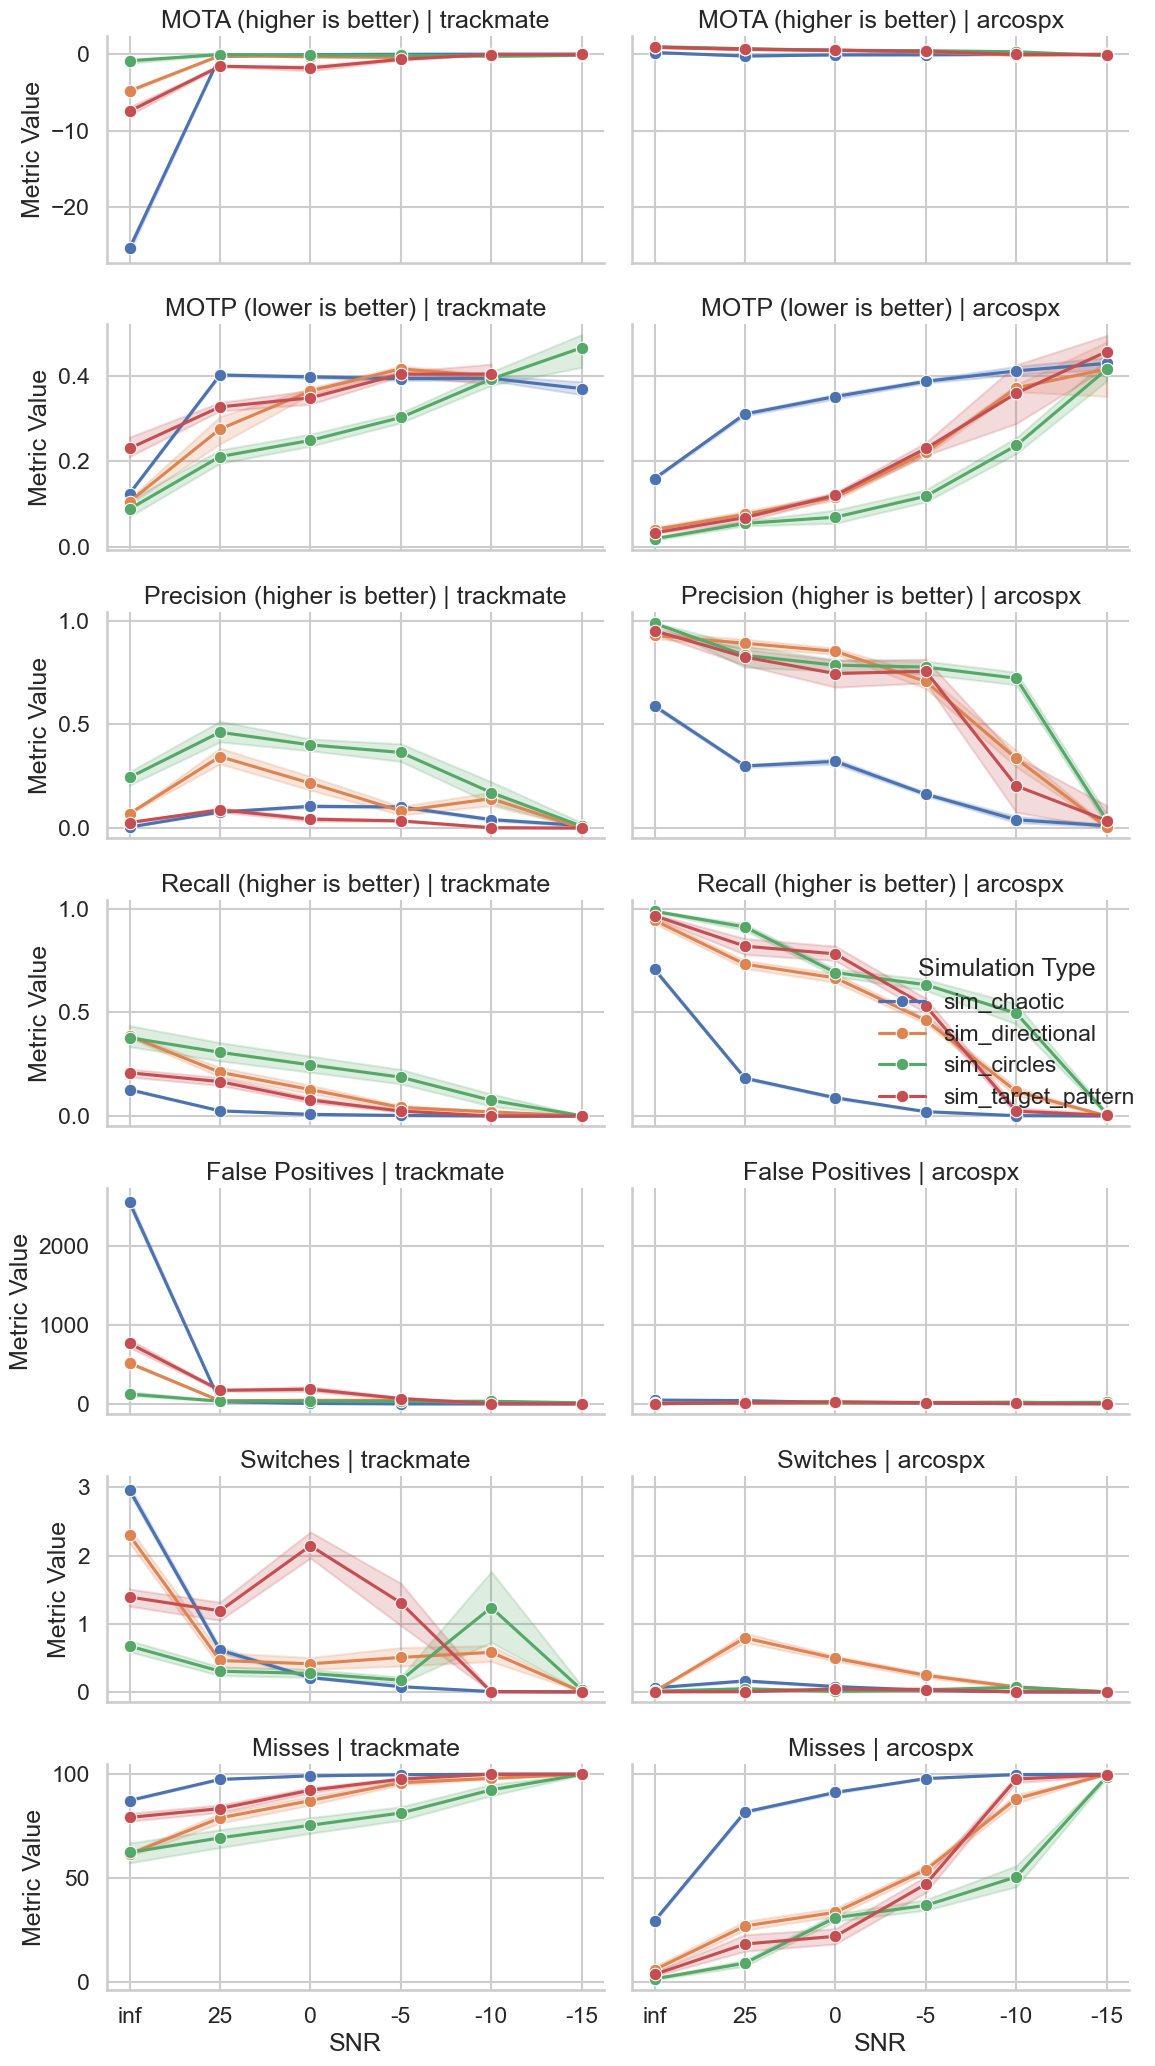

In [8]:
sns.set_style("ticks")
sns.set(style="whitegrid", context="talk")

df_rel = df.copy()
# Example: fix the 'snr' column in-place
df_rel['snr'] = df_rel['snr'].replace("inf", np.inf).astype(float)

# Get unique SNRs in descending numeric order
snr_sorted = np.sort(df_rel['snr'].unique())[::-1]  # descending

# Build string labels: "inf" for infinite, otherwise convert float to a short string
snr_labels = ["inf" if np.isinf(x) else f"{x:g}" for x in snr_sorted]

# Create a new column 'snr_str' that is a string for each numeric value
df_rel['snr_str'] = df_rel['snr'].apply(
    lambda x: "inf" if np.isinf(x) else f"{x:g}"
)

# Convert the snr_str column into an ordered categorical with the descending order
df_rel['snr_str'] = pd.Categorical(
    df_rel['snr_str'],
    categories=snr_labels,  # from largest (inf) to smallest
    ordered=True
)


g = sns.FacetGrid(
    df_rel,
    col='tracker_name',
    # col_wrap=4,
    row='Metric',
    sharey='row',  # Share y-axis within each metric column only
    # height=1,
    aspect=1.5
)
g.map_dataframe(
    sns.lineplot,
    x='snr_str',
    y='Value',
    hue='sim_type',
    marker='o'
)

# set y-axis to log scale for better visibility of differences
# g.set(yscale='log')  # or 'log' if you want logarithmic scale

# Add legend and labels
g.add_legend(title='Simulation Type')
g.set_axis_labels('SNR', 'Metric Value')
g.set_titles(col_template='{col_name}', row_template='{row_name}')

plt.tight_layout()
plt.show()

## Metric comparison on X-Y plots

In [9]:
# Pivot the DataFrame to prepare for plotting as a scatter plot: arcos vs TM
df_plot = df.pivot_table(
    index=['sim_type', 'snr', 'Metric', 'iteration'],
    columns='tracker_name',
    values='Value'
).reset_index()

# Re-order categories for plotting
df_plot['sim_type'] = pd.Categorical(df_plot['sim_type'],
                                       categories=['sim_circles', 'sim_directional', 'sim_target_pattern', 'sim_chaotic'], ordered=True)

In [10]:
def plot_metric_comparison(df, metric, scales, coord_fixed=False, xlim=None, ylim=None):     
    df_metric = df[df['Metric'] == metric]
    
    p = (p9.ggplot(df_metric, 
                   p9.aes(x='arcospx', 
                          y='trackmate')) +
        p9.geom_point(p9.aes(color = 'factor(snr)'),
                            size = 3, 
                            stroke=0, 
                            alpha = 0.65) +
        p9.scale_color_brewer(name = 'SNR', type='qual', palette='Dark2') +    
        p9.geom_abline(slope=1, intercept=0, color='red', linetype='dashed')
    )

    if scales in ['free', 'free_x', 'free_y']:
        p = (p +
            p9.facet_wrap('~sim_type', 
                       scales=scales,
                       labeller=p9.labeller(sim_type=lambda x: x.replace('_', ' ').title()),
                       ncol = 1)
        )
    else:
        p = (p +
            p9.facet_wrap('~sim_type', 
                       labeller=p9.labeller(sim_type=lambda x: x.replace('_', ' ').title()),
                       ncol = 1)
        )
    
    if coord_fixed:
        p = p + p9.coord_fixed(ratio=1, xlim=xlim, ylim=ylim)

    if xlim is not None:
        p = p + p9.xlim(xlim)

    if ylim is not None:
        p = p + p9.ylim(ylim)
    
    p = (p + 
        p9.theme_bw() +
        p9.labs(title=f'{metric}',
                 x='ARCOS.px',
                 y='TrackMate') +
        p9.theme_matplotlib() +
        p9.theme(
            legend_position='right',
            figure_size=(3, 8),
            panel_grid=p9.element_blank(),
            panel_border=p9.element_rect(size=0.5, colour="black"),
            panel_background=p9.element_blank(),
            text=p9.element_text(family="Helvetica"),
            axis_text_x=p9.element_text(colour="black", size=10),
            axis_text_y=p9.element_text(colour="black", size=10),
            axis_title_x=p9.element_text(colour="black", size=12),
            axis_title_y=p9.element_text(colour="black", size=12),
        )
    )
    
    return p

In [11]:
pMOTA = plot_metric_comparison(df_plot, 'MOTA (higher is better)', scales='free_y')
pMOTP = plot_metric_comparison(df_plot, 'MOTP (lower is better)', scales=None, coord_fixed=True, xlim=(0, .5), ylim=(0, .5))
pFP = plot_metric_comparison(df_plot, 'False Positives', scales='free_y')
pRecall = plot_metric_comparison(df_plot, 'Recall (higher is better)', scales=None, xlim=(0, 1), ylim=(0, 1))
pPrecision = plot_metric_comparison(df_plot, 'Precision (higher is better)', scales=None, xlim=(0, 1), ylim=(0, 1))
pMisses = plot_metric_comparison(df_plot, 'Misses', scales=None, coord_fixed=True, xlim=(0, 100), ylim=(0, 100))
pSwitches = plot_metric_comparison(df_plot, 'Switches', scales=None, xlim=(0, 1), ylim=(0, 3.5))


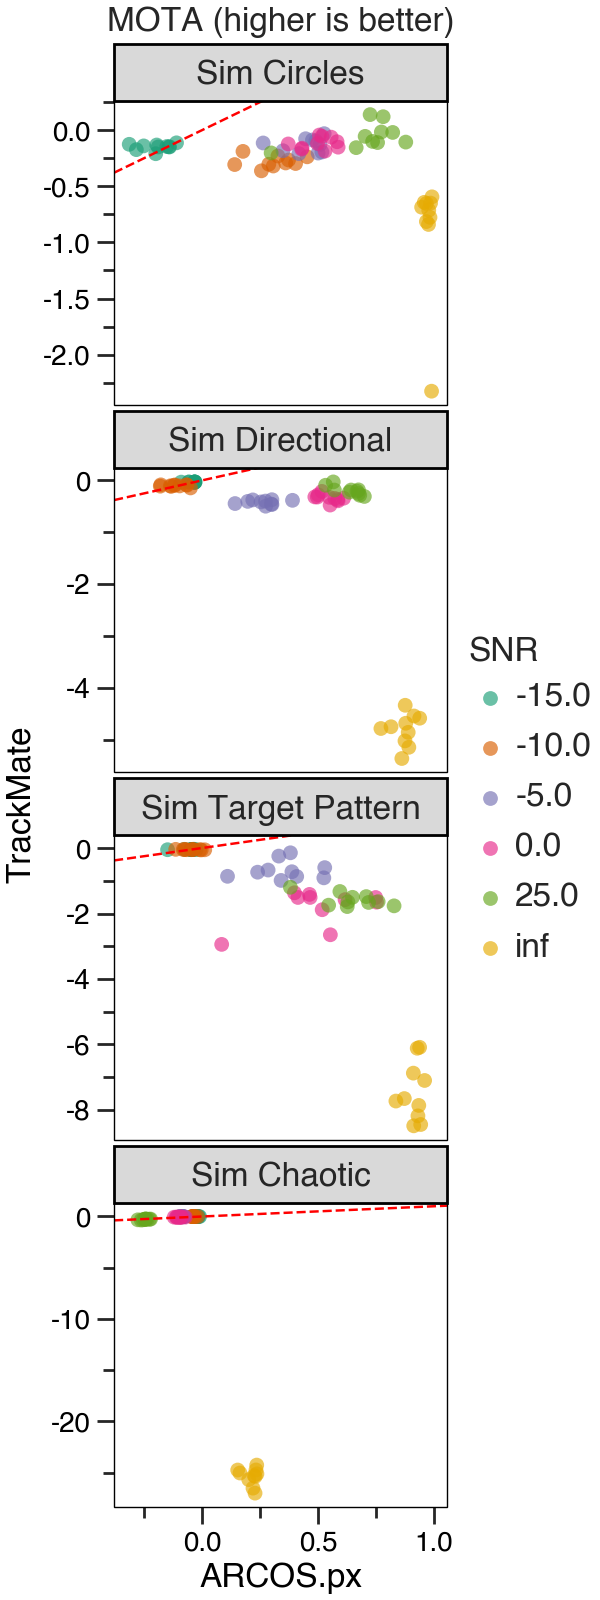

In [178]:
pMOTA

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 11 rows containing missing values.


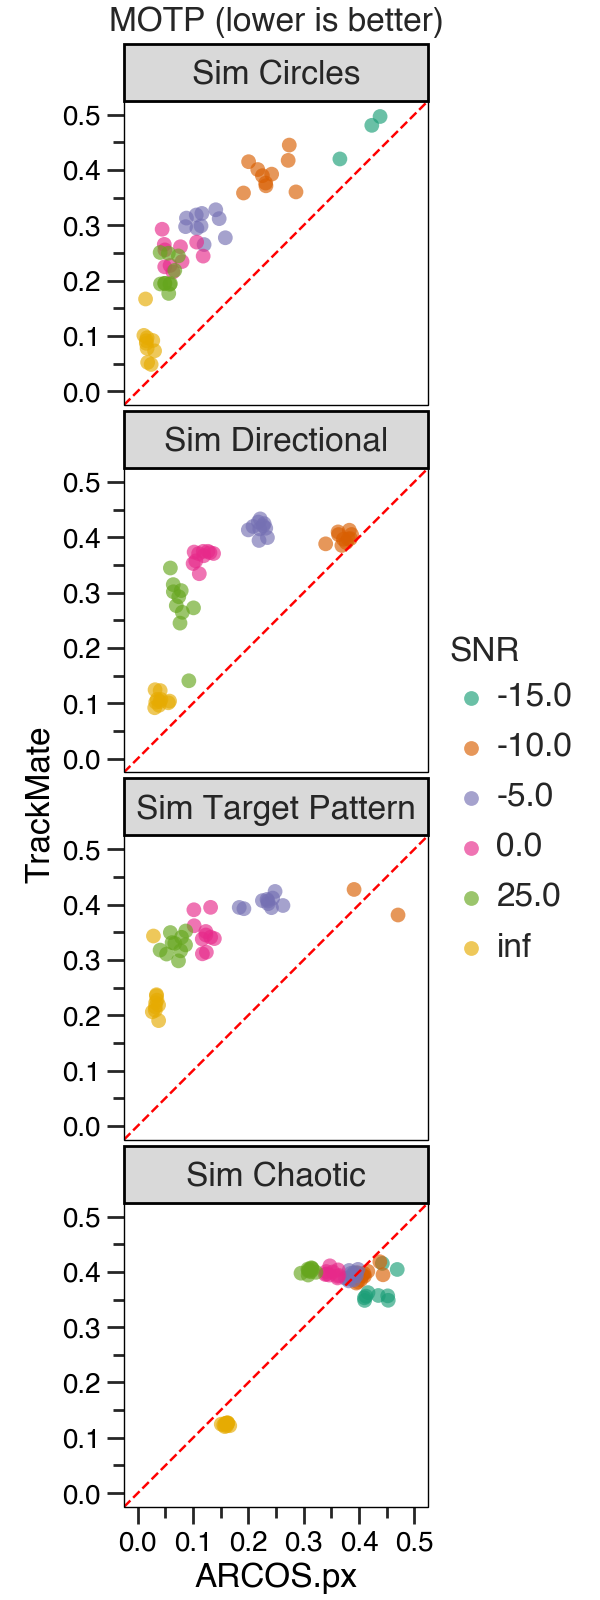

In [197]:
pMOTP

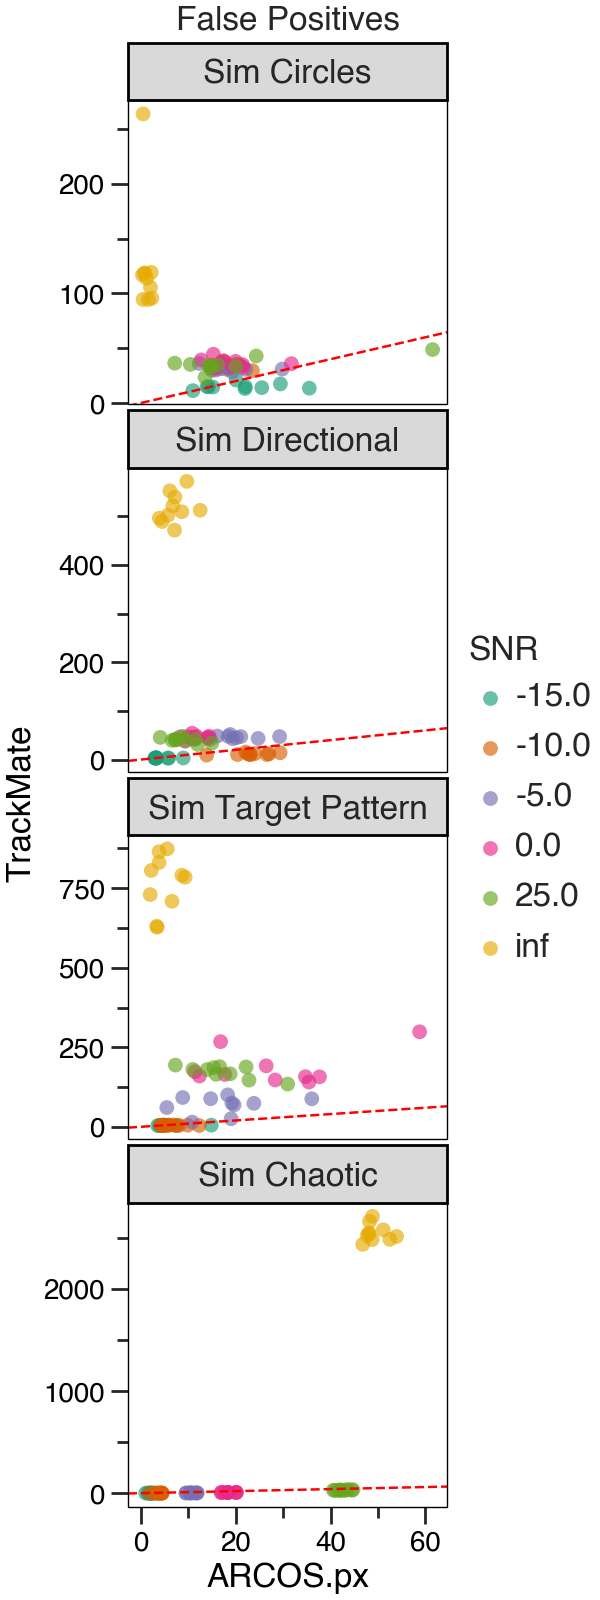

In [180]:
pFP

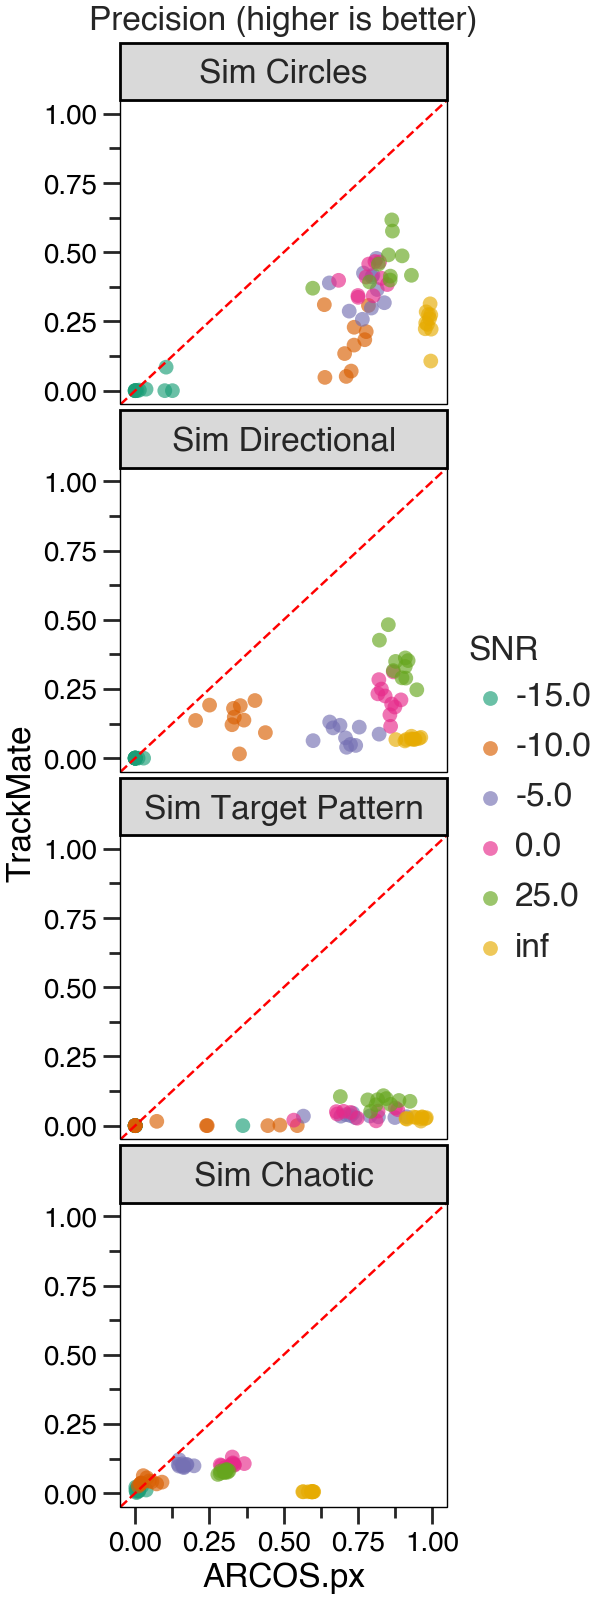

In [193]:
pPrecision

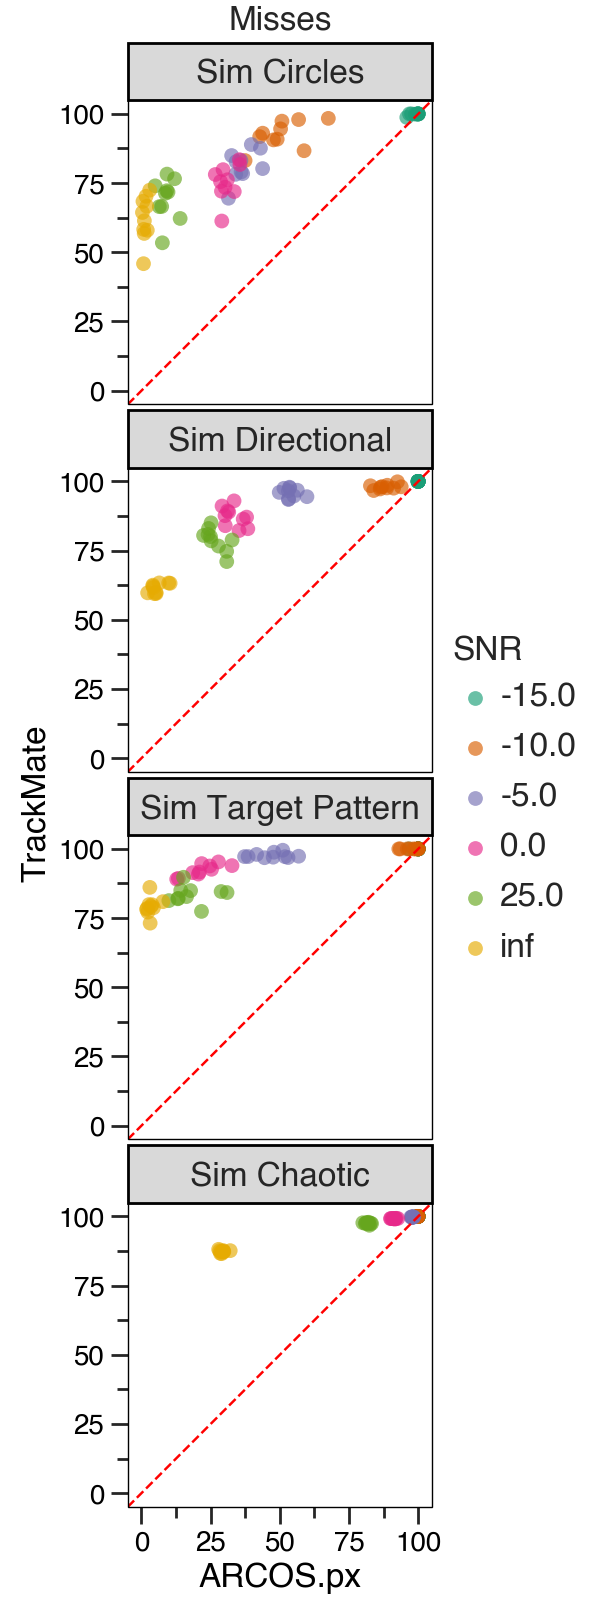

In [189]:
pMisses

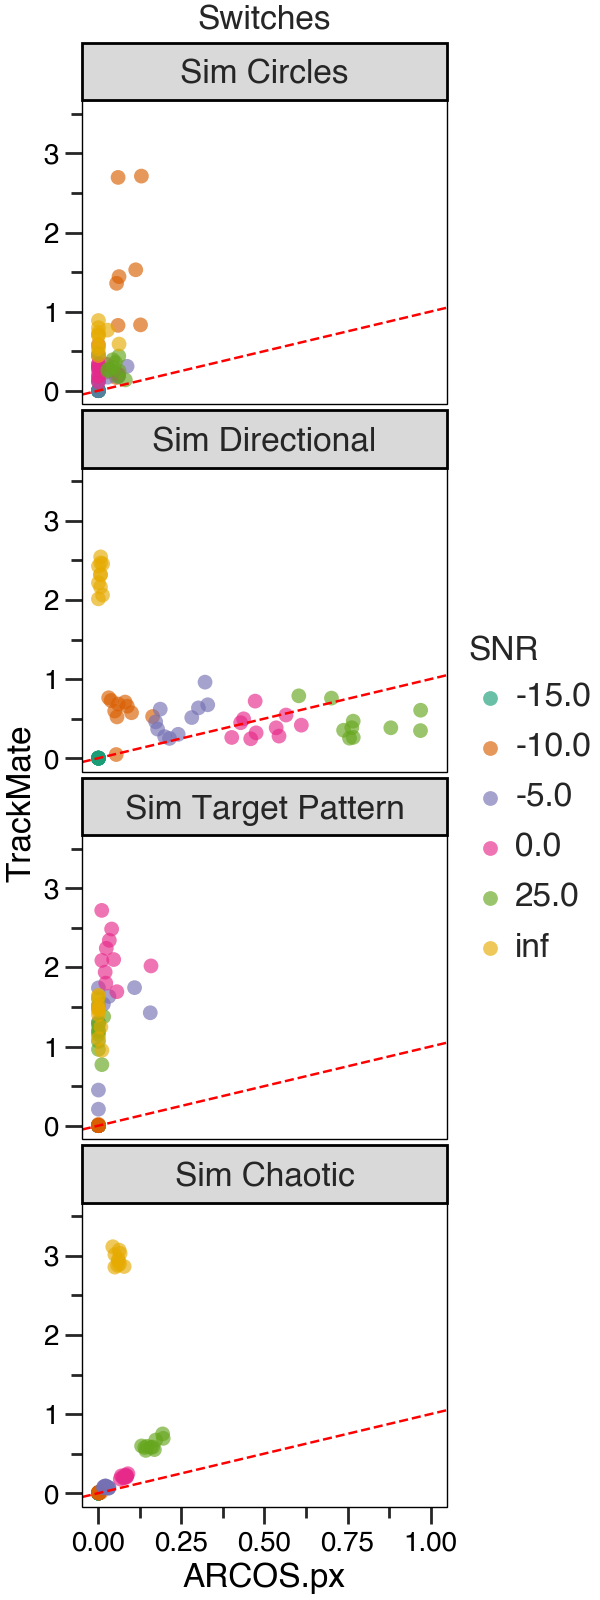

In [185]:
pSwitches

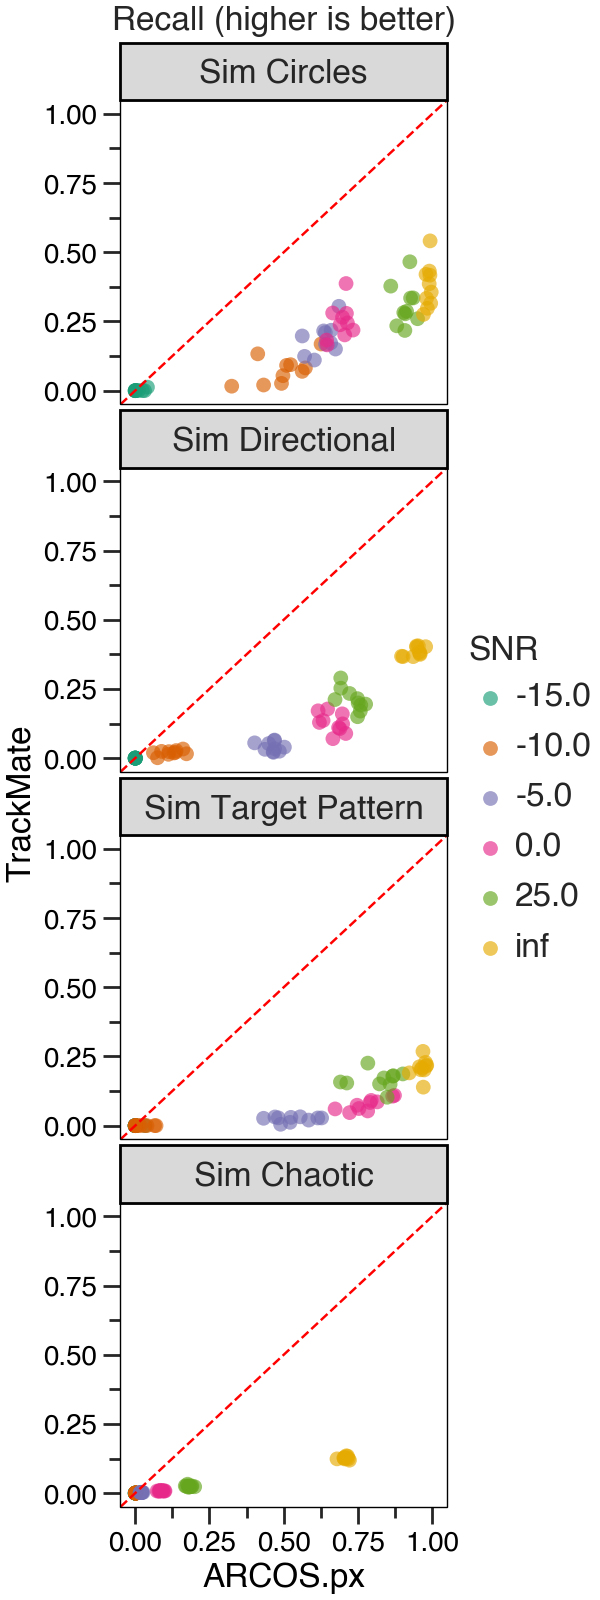

In [212]:
pRecall

In [ ]:
# Save plots to files
for ii in [pMOTA, pMOTP, pFP, pRecall, pPrecision, pMisses, pSwitches]:
    ii.save(os.path.join(PLOT_FOLDER, f'comp_{ii.labels.get('title', None)}.pdf'), dpi=300, width=3, height=8)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 8 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: evaluation_arcospx_run006/plots/comp_MOTA (higher is better).pdf
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 8 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: evaluation_arcospx_run006/plots/comp_MOTP (lower is better).pdf
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 8 in image.
/Users/maciekd/miniforge3/envs/

## Stats

In [181]:
metric_better_direction = {
    'MOTA (higher is better)': 'higher',
    'MOTP (lower is better)': 'lower',
    'Precision (higher is better)': 'higher',
    'Recall (higher is better)': 'higher',
    'False Positives': 'lower',
    'Switches': 'lower',
    'Misses': 'lower'
}

stats_res = {}

def hedges_correction_factor(df: int) -> float:
    """Calculate Hedges' correction factor J(df)"""
    return 1 - (3 / (4 * df - 1))

def _exact_ci_paired(method_a_data, method_b_data, confidence_level=0.95, hedges_correction=False) -> Tuple[float, float, float]:
    """
    Exact CI for paired Cohen's d using noncentral t-distribution
    Based on Hedges & Olkin (1985), Chapter 5
    """
    # Convert to numpy arrays
    a_data = np.array(method_a_data)
    b_data = np.array(method_b_data)

    # Basic statistics
    n = len(a_data)
    df = n - 1
    alpha = 1 - confidence_level

    # Paired analysis
    differences = b_data - a_data  # Method B - Method A
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)

    # Effect size (Cohen's d for paired data)
    cohens_d = mean_diff / std_diff

    j_df = hedges_correction_factor(df) if hedges_correction else 1  
    hedges_g = cohens_d * j_df

    # Observed noncentrality parameter
    delta_obs = cohens_d * np.sqrt(n)
    
    try:
        # Upper confidence limit for δ
        # Solve: P(T_{df,δ_U} ≤ δ_obs) = α/2
        def upper_equation(delta_u):
            return stats.t.cdf(delta_obs, df, delta_u) - alpha/2
        
        # Search range for upper limit (typically above observed delta)
        if delta_obs >= 0:
            delta_upper = brentq(upper_equation, delta_obs, delta_obs + 20)
        else:
            # For negative effects, upper limit might be less negative
            delta_upper = brentq(upper_equation, delta_obs, 20)
            
        # Lower confidence limit for δ  
        # Solve: P(T_{df,δ_L} ≤ δ_obs) = 1 - α/2
        def lower_equation(delta_l):
            return stats.t.cdf(delta_obs, df, delta_l) - (1 - alpha/2)
        
        # Search range for lower limit (typically below observed delta)
        if delta_obs <= 0:
            delta_lower = brentq(lower_equation, delta_obs - 20, delta_obs)
        else:
            # For positive effects, lower limit might be negative
            delta_lower = brentq(lower_equation, -20, delta_obs)
                                
    except (ValueError, RuntimeError):
        # Fallback to approximate method if numerical issues
        # Use improved approximate SE for paired design
        r_estimate = 0.5  # Conservative correlation estimate if unknown
        se_d = np.sqrt(2 * (1 - r_estimate) / n + (cohens_d**2) / (2 * n))
        t_crit = stats.t.ppf(1 - alpha/2, df)
        
        delta_lower = (cohens_d - t_crit * se_d) * np.sqrt(n)
        delta_upper = (cohens_d + t_crit * se_d) * np.sqrt(n)
    
    # Convert back to Cohen's d scale and apply Hedges correction
    d_lower = (delta_lower / np.sqrt(n)) * j_df
    d_upper = (delta_upper / np.sqrt(n)) * j_df
    
    return hedges_g, d_lower, d_upper

def _approximate_ci_paired_norm(method_a_data, method_b_data, 
                           confidence_level: float = 0.95, 
                           hedges_correction: bool = False) -> Tuple[float, float, float, float]:
    """
    Approximate CI for paired Cohen's d using normal approximation
    """

    # Convert to numpy arrays
    a_data = np.array(method_a_data)
    b_data = np.array(method_b_data)

    # Basic statistics
    n = len(a_data)
    df = n - 1
    alpha = 1 - confidence_level

    # Paired analysis
    differences = b_data - a_data  # Method B - Method A
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)

    # Effect size (Cohen's d for paired data)
    cohens_d = mean_diff / std_diff

    j_df = hedges_correction_factor(df) if hedges_correction else 1  
    hedges_g = cohens_d * j_df

    # Approximate standard error for paired Cohen's d
    se_d = np.sqrt((2 * (1 - np.corrcoef(a_data, b_data)[0,1])) / n + 
                    (cohens_d**2) / (2 * n))
    
    # Apply correction to SE (approximate)
    se_g = se_d * j_df
    
    # Normal approximation CI
    z_alpha = stats.norm.ppf(1 - alpha/2)
    ci_lower = hedges_g - z_alpha * se_g
    ci_upper = hedges_g + z_alpha * se_g
    
    return hedges_g, ci_lower, ci_upper, se_g

def _approximate_ci_paired_t(method_a_data, method_b_data, 
                           confidence_level: float = 0.95, 
                           hedges_correction: bool = False) -> Tuple[float, float, float, float]:
    """
    Approximate CI for paired Cohen's d using normal approximation
    """

    # Convert to numpy arrays
    a_data = np.array(method_a_data)
    b_data = np.array(method_b_data)

    # Basic statistics
    n = len(a_data)
    df = n - 1
    alpha = 1 - confidence_level

    # Paired analysis
    differences = b_data - a_data  # Method B - Method A
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    
    # Effect size (Cohen's d for paired data)
    cohens_d = mean_diff / std_diff

    if hedges_correction:
        j_df = hedges_correction_factor(df)
    else:
        j_df = 1

    hedges_g = cohens_d * j_df

    # Critical values
    alpha = 1 - confidence_level
    t_critical = stats.t.ppf(1 - alpha/2, df)
    
    # Confidence interval for Cohen's d (Hedges & Olkin method)
    #se_d = np.sqrt((1/n + cohens_d**2/(2*n)) * 2 * (1 - 1/(4*df - 1)))
    
    # with correlation correction
    r = np.corrcoef(a_data, b_data)[0, 1]
    if r is None:
        r = 0.
    se_d = np.sqrt((2 * (1 - r)) / n + (cohens_d**2) / (2 * n))

    se_g = se_d * j_df

    ci_lower = hedges_g - t_critical * se_g
    ci_upper = hedges_g + t_critical * se_g
    
    return hedges_g, ci_lower, ci_upper, se_d

def _bootstrap_ci_paired(group1: np.ndarray, group2: np.ndarray, 
                        confidence_level: float = 0.95, 
                        n_bootstrap: int = 10000,
                        hedges_correction: bool = False,
                        random_seed: int = 42) -> Tuple[float, float, float, float]:
    """Bootstrap confidence interval for paired Hedges' g"""
    
    n = len(group1)
    df = n - 1
    j_df = hedges_correction_factor(df) if hedges_correction else 1  
    
    # Generate bootstrap samples
    np.random.seed(random_seed) 

    bootstrap_gs = np.zeros(n_bootstrap)
    for iter in range(n_bootstrap):
        # Resample pairs with replacement
        indices = np.random.choice(n, size=n, replace=True)
        boot_group1 = group1[indices]
        boot_group2 = group2[indices]
        
        # Calculate Hedges' g for this bootstrap sample
        boot_diff = boot_group2 - boot_group1
        boot_d = np.mean(boot_diff) / np.std(boot_diff, ddof=1)
        boot_g = boot_d * j_df
        bootstrap_gs[iter] = boot_g
    
    bootstrap_gs = np.array(bootstrap_gs)
    
    # Calculate percentile CI
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_gs, 100 * alpha/2)
    ci_upper = np.percentile(bootstrap_gs, 100 * (1 - alpha/2))
    mean_estimate = np.mean(bootstrap_gs)
    se_estimate = np.std(bootstrap_gs)
    
    return mean_estimate, ci_lower, ci_upper, se_estimate

def calculate_effects(method_a_data, 
                      method_b_data, 
                      sim_type,
                      metric_name,
                      snr,
                      confidence_level=0.95, 
                      better_direction='higher',
                      hedges_correction=False):
    """
    Calculate paired t-test and effect size for each metric and SNR.
    Returns a dictionary with results.
    """
    # Convert to numpy arrays
    a_data = np.array(method_a_data)
    b_data = np.array(method_b_data)
    
    # Basic statistics
    n = len(a_data)
    mean_a = np.mean(a_data)
    mean_b = np.mean(b_data)
    std_a = np.std(a_data, ddof=1)
    std_b = np.std(b_data, ddof=1)
    
    # Paired analysis
    differences = b_data - a_data  # Method B - Method A
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    se_diff = std_diff / np.sqrt(n)
    
    # T-test
    t_stat, p_value = stats.ttest_rel(a_data, b_data)
    df = n - 1
    
    # Critical values
    alpha = 1 - confidence_level
    t_critical = stats.t.ppf(1 - alpha/2, df)
    
    # Confidence intervals for mean difference
    diff_ci_lower = mean_diff - t_critical * se_diff
    diff_ci_upper = mean_diff + t_critical * se_diff
    
    # Effect size (Cohen's d for paired data)
    cohens_d = mean_diff / std_diff
    
    # Apply Hedges' correction if specified
    j_df = hedges_correction_factor(df) if hedges_correction else 1  # Hedges' correction factor
    
    # Confidence interval for Cohen's d (Hedges & Olkin method)
    se_d = np.sqrt((1/n + cohens_d**2/(2*n)) * 2 * (1 - 1/(4*df - 1)))
    d_ci_lower = cohens_d - t_critical * se_d
    d_ci_upper = cohens_d + t_critical * se_d
    
    d_ci_lower_exact, d_ci_upper_exact = _exact_ci_paired(cohens_d, j_df, n, df, alpha)
    d_ci_lower_approx, d_ci_upper_approx = _approximate_ci_paired(a_data, b_data, confidence_level)
    #d_ci_lower_boot, d_ci_upper_boot, dummy = _bootstrap_ci_paired(a_data, b_data, confidence_level, 100)
    

    if better_direction == 'higher':
        winner = 'Method B' if mean_b > mean_a else 'Method A'
        improvement = ((mean_b - mean_a) / mean_a) * 100 if mean_a != 0 else np.inf
    else:
        winner = 'Method B' if mean_b < mean_a else 'Method A'  
        improvement = ((mean_a - mean_b) / mean_a) * 100 if mean_a != 0 else np.inf
    
    # Effect size interpretation
    def interpret_effect_size(d):
        abs_d = abs(d)
        if abs_d < 0.2:
            return "Negligible"
        elif abs_d < 0.5:
            return "Small"
        elif abs_d < 0.8:
            return "Medium"
        else:
            return "Large"
    
    # Significance interpretation
    def get_significance_level(p):
        if p < 0.001:
            return "***"
        elif p < 0.01:
            return "**"
        elif p < 0.05:
            return "*"
        else:
            return "ns"
    
    return {
        'sim_type': sim_type,
        'metric': metric_name,
        'snr': snr,
        'n_repetitions': n,
        'method_a_mean': mean_a,
        'method_a_std': std_a,
        'method_b_mean': mean_b,
        'method_b_std': std_b,
        'mean_difference': mean_diff,
        'mean_diff_ci': (diff_ci_lower, diff_ci_upper),
        'percent_improvement': improvement,
        'cohens_d': cohens_d,
        'cohens_d_hedges_correction_factor': j_df,
        'cohens_d_ci': (d_ci_lower, d_ci_upper),
        'cohens_d_ci_exact': (d_ci_lower_exact, d_ci_upper_exact),
        'cohens_d_ci_approx': (d_ci_lower_approx, d_ci_upper_approx),
        #'cohens_d_ci_boot': (d_ci_lower_boot, d_ci_upper_boot),
        'effect_size_interpretation': interpret_effect_size(cohens_d),
        't_statistic': t_stat,
        'p_value': p_value,
        'significance': get_significance_level(p_value),
        'winner': winner,
        'confidence_level': confidence_level,
        'degrees_freedom': df
    }

In [214]:
df

,sim_type,snr,tracker_name,iteration,Metric,Value
0,sim_chaotic,25.0,trackmate,9,MOTA (higher is better),-0.251473
1,sim_chaotic,25.0,arcospx,2,MOTA (higher is better),-0.235842
2,sim_chaotic,25.0,trackmate,3,MOTA (higher is better),-0.323795
3,sim_chaotic,25.0,trackmate,6,MOTA (higher is better),-0.317167
4,sim_chaotic,25.0,arcospx,0,MOTA (higher is better),-0.242713
...,...,...,...,...,...,...
3355,sim_circles,0.0,arcospx,7,Misses,29.021130
3356,sim_circles,0.0,arcospx,8,Misses,33.524747
3357,sim_circles,0.0,trackmate,2,Misses,79.855683
3358,sim_circles,0.0,arcospx,5,Misses,26.674938


In [ ]:
for sim_type in df['sim_type'].unique():
    for metric in df['Metric'].unique():
        for snr in df['snr'].unique():
            print(f"Processing simtype: {sim_type}, metric: {metric}, SNR: {snr}")

            # Filter data for the current metric and SNR
            method_a_data = df[(df['tracker_name'] == 'arcospx') & (df['sim_type'] == sim_type) & (df['Metric'] == metric) & (df['snr'] == snr)]['Value'].values
            method_b_data = df[(df['tracker_name'] == 'trackmate') & (df['sim_type'] == sim_type) & (df['Metric'] == metric) & (df['snr'] == snr)]['Value'].values

            stats_res[sim_type, metric, snr] = calculate_effects(
                method_a_data, 
                method_b_data, 
                sim_type=sim_type,
                metric_name=metric, 
                snr=snr,
                confidence_level=0.95, 
                better_direction=metric_better_direction.get(metric),
                hedges_correction=True   
            )

In [185]:
mota_method1 = np.array([0.85, 0.78, 0.82, 0.88, 0.75, 0.90, 0.83, 0.79, 0.86, 0.81])
mota_method2 = np.array([0.80, 0.75, 0.79, 0.82, 0.73, 0.85, 0.78, 0.76, 0.83, 0.77])
_approximate_ci_paired_t(mota_method1, mota_method2, confidence_level=0.95, hedges_correction=False)


(-3.0310473968824128,
 -4.572218113372583,
 -1.489876680392243,
 0.6812836622481697)

In [187]:
_bootstrap_ci_paired(mota_method1, mota_method2, confidence_level=0.95, n_bootstrap=10000, hedges_correction=False, random_seed=42)

(-3.331281082688942, -4.86265920515252, -2.405176623057146, 0.663591307824166)

In [186]:
_exact_ci_paired(mota_method1, mota_method2, confidence_level=0.95, hedges_correction=False)

(-3.0310473968824128, -3.746404302853077, -2.3156904909117513)

In [213]:
import pingouin as pg

nx, ny = len(mota_method1), len(mota_method2)
stat = pg.compute_effsize(mota_method2, mota_method1, eftype='cohen', paired=True)
ci = pg.compute_esci(stat=stat, nx=nx, ny=ny, eftype='cohen')
print(round(stat, 4), ci)

-0.9197 [-1.91  0.07]


In [110]:
stats_res[('sim_circles', 'MOTP (lower is better)', 25)]

{'sim_type': 'sim_circles',
 'metric': 'MOTP (lower is better)',
 'snr': 25.0,
 'n_repetitions': 10,
 'method_a_mean': 0.05480925846231529,
 'method_a_std': 0.010473611182356934,
 'method_b_mean': 0.21113176997117078,
 'method_b_std': 0.0275087200632134,
 'mean_difference': 0.15632251150885554,
 'mean_diff_ci': (0.13488088293892192, 0.17776414007878916),
 'percent_improvement': -285.21187094026595,
 'cohens_d': 5.215386872530258,
 'cohens_d_hedges_correction_factor': 0.9142857142857143,
 'cohens_d_ci': (1.4054167374001256, 9.025357007660391),
 'cohens_d_ci_exact': (2.185089553075991, 7.351617870979339),
 'cohens_d_ci_approx': (2.7586904691667335, 7.672083275893783),
 'effect_size_interpretation': 'Large',
 't_statistic': -16.492501396137865,
 'p_value': 4.936788334695371e-08,
 'significance': '***',
 'winner': 'Method A',
 'confidence_level': 0.95,
 'degrees_freedom': 9}

In [68]:
df_stats = pd.DataFrame(list(stats_res.values()))
df_stats[['mean_diff_ci_lower', 'mean_diff_ci_upper']] = pd.DataFrame(df_stats['mean_diff_ci'].tolist(), index=df_stats.index)
df_stats[['cohens_d_ci_lower', 'cohens_d_ci_upper']] = pd.DataFrame(df_stats['cohens_d_ci'].tolist(), index=df_stats.index)
df_stats = df_stats.drop(columns=['mean_diff_ci', 'cohens_d_ci'])

# Re-order categories for plotting
df_stats['sim_type'] = pd.Categorical(df_stats['sim_type'],
                                       categories=['sim_circles', 'sim_directional', 'sim_target_pattern', 'sim_chaotic'], ordered=True)

df_stats['metric'] = pd.Categorical(df_stats['metric'],
                                       categories=['False Positives', 'Precision (higher is better)', 'Recall (higher is better)', 'MOTA (higher is better)', 'MOTP (lower is better)', 'Switches', 'Misses'], ordered=True)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


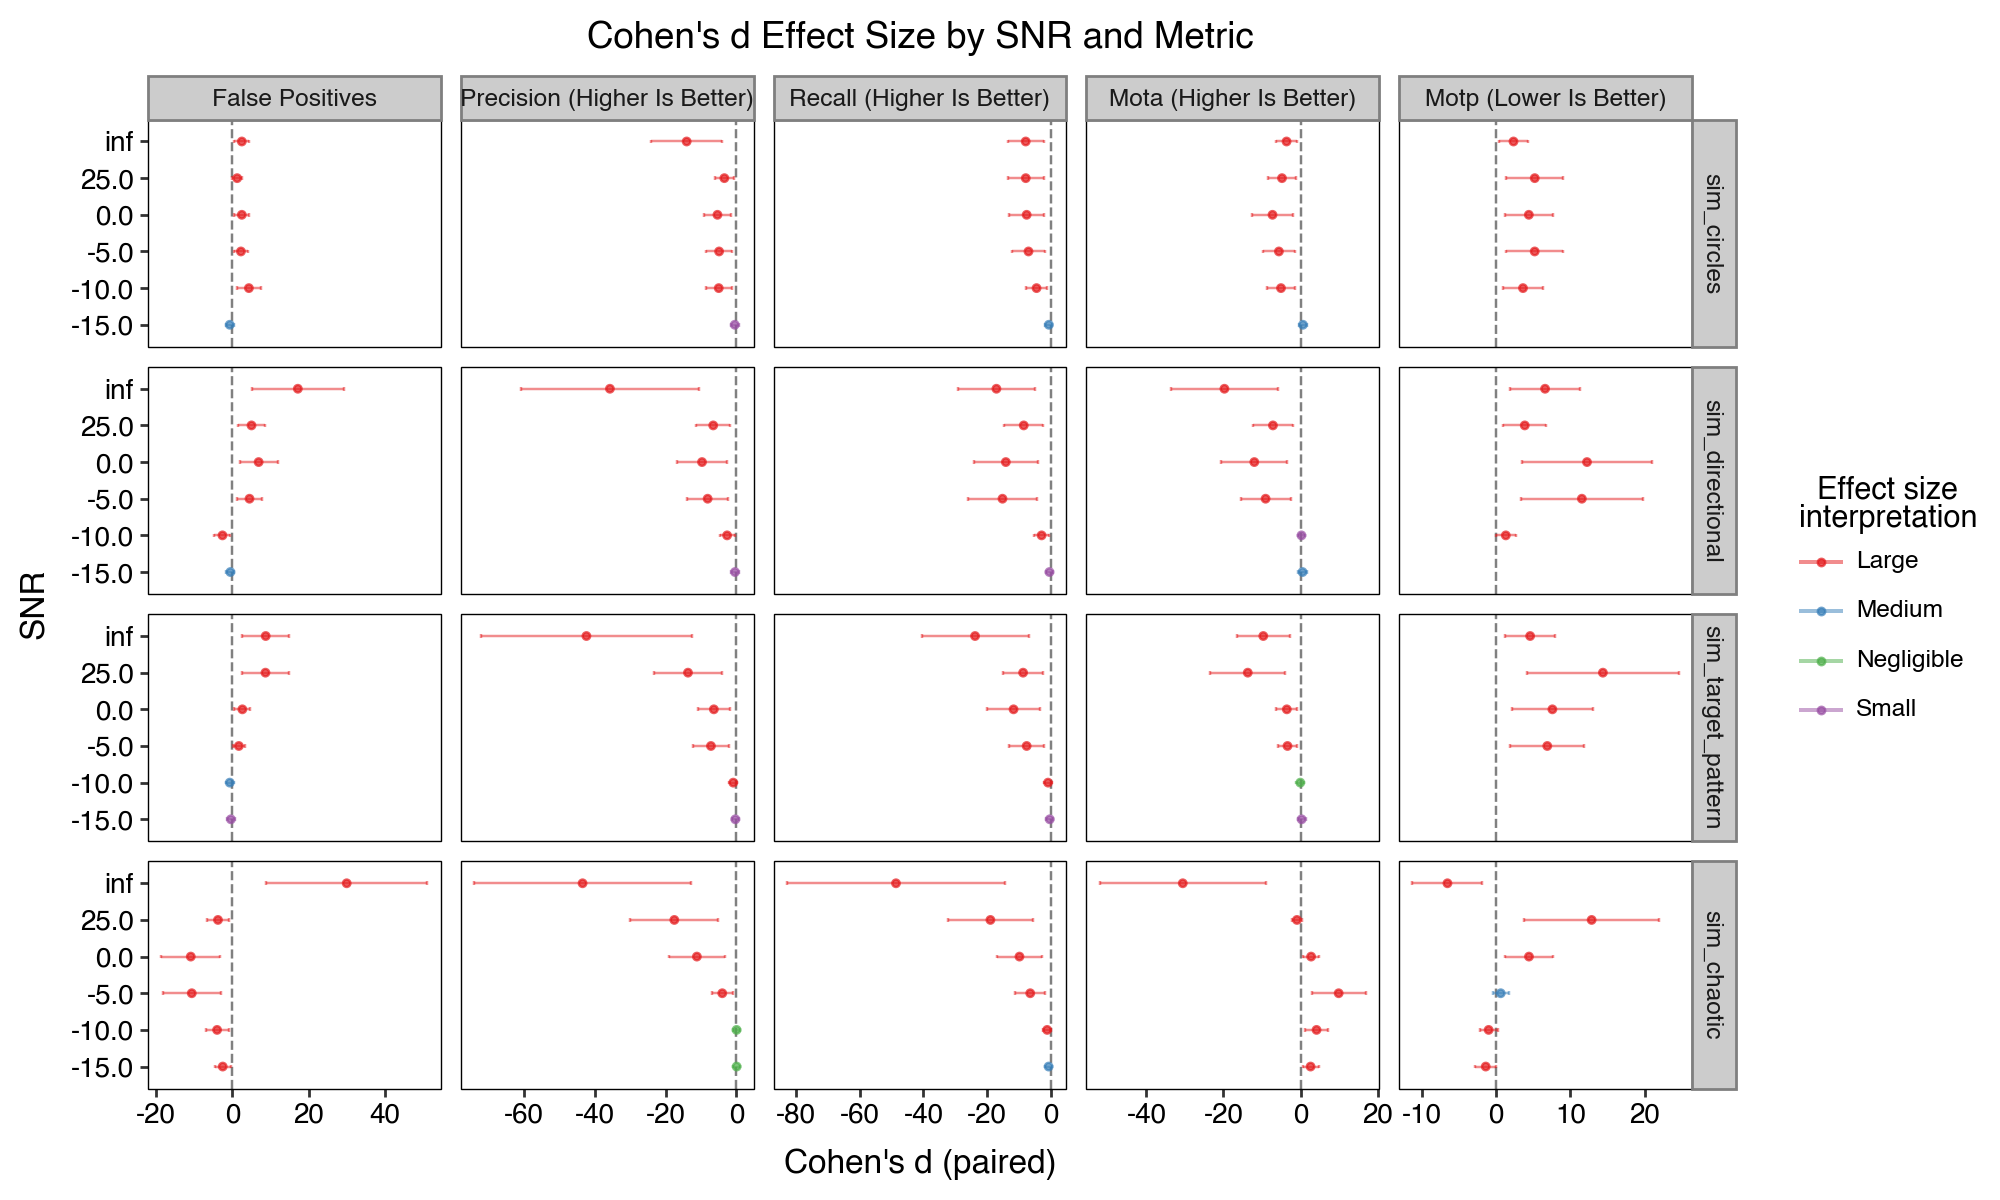

In [34]:
sns.set(style="white", context="talk")
pStats = (
    p9.ggplot(df_stats[df_stats['metric'].isin(['MOTA (higher is better)', 'MOTP (lower is better)', 'Recall (higher is better)', 'Precision (higher is better)', 'False Positives'])],
              p9.aes(x='factor(snr)', 
                     y='cohens_d', 
                     color='effect_size_interpretation')) +
    p9.geom_hline(yintercept=0, linetype='dashed', color='grey', size=0.5) +
    p9.geom_point(size=1, alpha=0.7) +
    p9.geom_errorbar(
        p9.aes(ymin='cohens_d_ci_lower', ymax='cohens_d_ci_upper'), 
        width=0.1, alpha=0.5, size=0.5
    ) +
    p9.coord_flip() +
    p9.scale_color_brewer(name='Effect size\ninterpretation', type='qual', palette='Set1') +
    p9.facet_grid('sim_type~metric', scales='free_x', 
                  labeller=p9.labeller(metric=lambda x: x.replace('_', ' ').title())) +
    p9.theme_bw() +
    p9.labs(title="Cohen's d Effect Size by SNR and Metric",
             x='SNR', y="Cohen's d (paired)") +
    p9.theme(
        legend_position='right',
        figure_size=(10, 6),
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Helvetica"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

pStats

In [300]:
pStats.save(os.path.join(PLOT_FOLDER, 'stats_cohensd.pdf'), dpi=300, width=10, height=6)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 10 x 6 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: evaluation_arcospx_run006/plots/stats_cohensd.pdf
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


# Movie with ARCOS.px & TrackMate comparison

In [21]:
sns.set(style="dark", context="talk")

create_combined_animation(['sim_chaotic', 'sim_circles', 'sim_directional', 'sim_target_pattern'], 'evaluation_arcospx_run006')

'Frame 163 / 167'